# Classificação de imagens de cães vs gatos com aumento de imagem

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Neste tutorial, discutiremos como classificar imagens em imagens de gatos ou imagens de cães. Vamos construir um classificador de imagem usando o modelo `tf.keras.Sequential` e carregar os dados usando` tf.keras.preprocessing.image.ImageDataGenerator`.

## Conceitos específicos que serão cobertos:
No processo, construiremos experiência prática e desenvolveremos intuição em torno dos seguintes conceitos

* Construindo _ pipelines de entrada de dados_ usando a classe `tf.keras.preprocessing.image.ImageDataGenerator` - Como podemos trabalhar eficientemente com dados no disco para fazer interface com nosso modelo?
* _Overfitting_ - o que é, como identificá-lo e como podemos evitá-lo?
* _Aumento de dados_ e _Dropout_ - Técnicas-chave para combater o sobreajuste em tarefas de visão computacional que iremos incorporar em nosso pipeline de dados e modelo de classificador de imagem.

## Seguiremos o fluxo de trabalho geral do aprendizado de máquina:

1. Examine e compreenda os dados
2. Construir um pipeline de entrada
3. Construir nosso modelo
4. Treine nosso modelo
5. Teste nosso modelo
6. Melhore nosso modelo / Repita o processo

<hr>

**Antes de você começar**

Antes de executar o código neste notebook, redefina o tempo de execução indo para ** Runtime -> Redefinir todos os tempos de execução ** no menu acima. Se você tem trabalhado em vários notebooks, isso o ajudará a evitar atingir os limites de memória do Colab.


# Importando pacotes

Vamos começar importando os pacotes necessários:

* os - para ler arquivos e estrutura de diretório
* numpy - para alguma matemática de matriz fora do TensorFlow
* matplotlib.pyplot - para traçar o gráfico e exibir imagens em nossos dados de treinamento e validação

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados

Para construir nosso classificador de imagens, começamos baixando o conjunto de dados. O conjunto de dados que estamos usando é uma versão filtrada do conjunto de dados <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank"> Cães vs. Gatos </a> do Kaggle (em última análise, este conjunto de dados é fornecido pela Microsoft Research).

faremos uso da classe `tf.keras.preprocessing.image.ImageDataGenerator` que irá ler os dados do disco. Portanto, precisamos baixar * Dogs vs. Cats * diretamente de um URL e descompactá-lo para o sistema de arquivos Colab.

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 73s 1us/step


O conjunto de dados que baixamos tem a seguinte estrutura de diretório.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

O conjunto de dados que baixamos tem o seguinte Vamos agora atribuir variáveis com o caminho de arquivo adequado para os conjuntos de treinamento e validação.

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Compreendendo nossos dados

Vejamos quantas imagens de cães e gatos temos em nosso diretório de treinamento e validação

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Configurando parâmetros do modelo

Por conveniência, vamos configurar variáveis que serão usadas mais tarde durante o pré-processamento de nosso conjunto de dados e treinamento de nossa rede.

In [9]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

Depois de definir nossos geradores para imagens de treinamento e validação, o método ** flow_from_directory ** carregará as imagens do disco e aplicará o reescalonamento e redimensioná-las nas dimensões necessárias usando uma única linha de código.

# Data Augmentation

O overfitting geralmente ocorre quando temos um pequeno número de exemplos de treinamento. Uma maneira de corrigir esse problema é aumentar nosso conjunto de dados para que tenha um número suficiente e variedade de exemplos de treinamento. O aumento de dados adota a abordagem de gerar mais dados de treinamento a partir de amostras de treinamento existentes, aumentando as amostras por meio de transformações aleatórias que produzem imagens de aparência confiável. O objetivo é que, na hora do treinamento, seu modelo nunca veja exatamente a mesma imagem duas vezes. Isso expõe o modelo a mais aspectos dos dados, permitindo uma generalização melhor.

Em ** tf.keras ** podemos implementar isso usando a mesma classe ** ImageDataGenerator ** que usamos antes. Podemos simplesmente passar diferentes transformações que desejaríamos para nosso conjunto de dados como uma forma de argumentos e ele se encarregará de aplicá-las ao conjunto de dados durante nosso processo de treinamento.

Para começar, vamos definir uma função que pode exibir uma imagem, para que possamos ver o tipo de aumento que foi executado. Em seguida, veremos aumentos específicos que usaremos durante o treinamento.

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Invertendo a imagem horizontalmente

### Invertendo a imagem horizontalmente Podemos começar aplicando aleatoriamente o aumento da inversão horizontal ao nosso conjunto de dados e vendo como as imagens individuais ficarão após a transformação. Isso é obtido passando `horizontal_flip = True` como um argumento para a classe` ImageDataGenerator`.

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


Para ver a transformação em ação, vamos pegar uma imagem de amostra de nosso conjunto de treinamento e repeti-la cinco vezes. O aumento será aplicado aleatoriamente (ou não) a cada repetição.

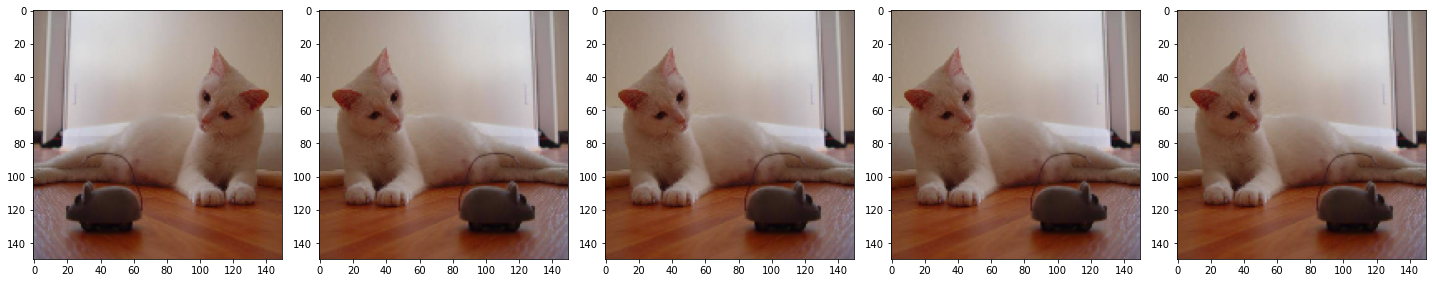

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Girando a imagem

O aumento da rotação irá girar aleatoriamente a imagem até um determinado número de graus. Aqui, vamos definir para 45.

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


Para ver a transformação em ação, vamos mais uma vez pegar uma imagem de amostra de nosso conjunto de treinamento e repeti-la. O aumento será aplicado aleatoriamente (ou não) a cada repetição.

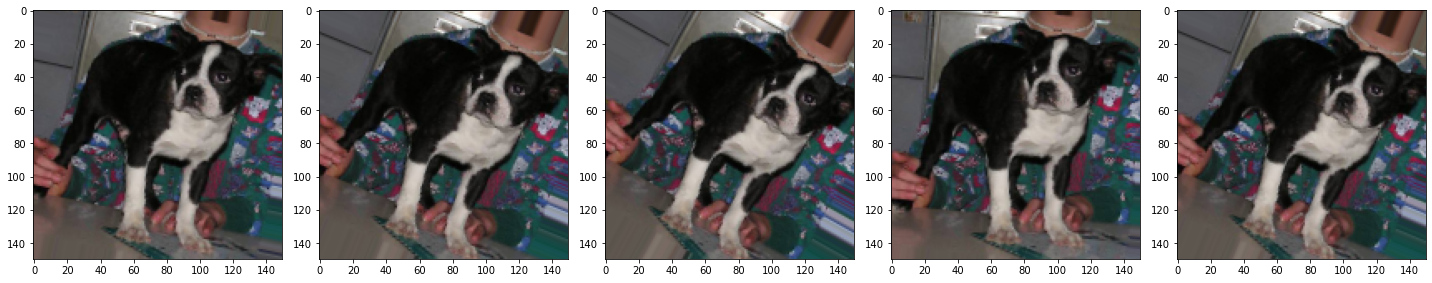

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Aplicando Zoom

Também podemos aplicar o aumento do zoom ao nosso conjunto de dados, ampliando as imagens em até 50% aleatoriamente.

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


Mais uma vez, pegue uma imagem de amostra de nosso conjunto de treinamento e repita-a. O aumento será aplicado aleatoriamente (ou não) a cada repetição.

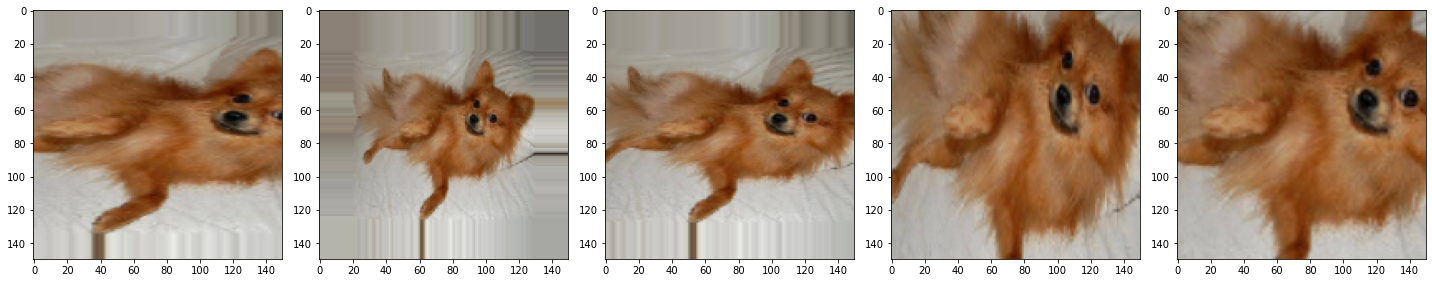

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Juntando tudo

Podemos aplicar todos esses acréscimos, e até outros, com apenas uma linha de código, passando os acréscimos como argumentos com valores adequados.

Aqui, aplicamos redimensionamento, rotação de 45 graus, deslocamento de largura, deslocamento de altura, inversão horizontal e aumento de zoom às nossas imagens de treinamento.

In [17]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Vamos visualizar como uma única imagem ficaria cinco vezes diferentes, quando passamos esses aumentos aleatoriamente para nosso conjunto de dados.

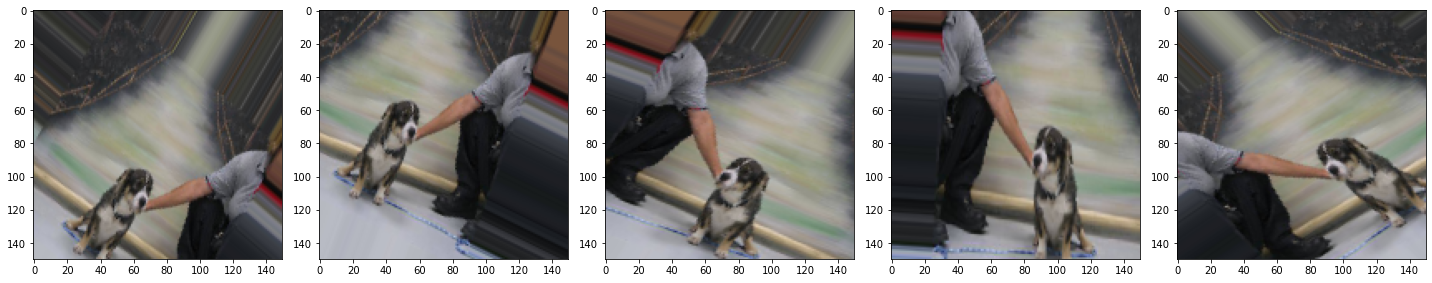

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Criando gerador de dados de validação

Geralmente, aplicamos apenas aumento de dados em nossos exemplos de treinamento, uma vez que as imagens originais devem ser representativas do que nosso modelo precisa gerenciar. Portanto, neste caso, estamos apenas redimensionando nossas imagens de validação e convertendo-as em lotes usando ImageDataGenerator.

In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# criando o modelo

## Defina o modelo

O modelo consiste em quatro blocos de convolução com uma camada máxima de pool em cada um deles.

Antes das camadas Densas finais, também estamos aplicando uma probabilidade de dropout de 0,5. Isso significa que 50% dos valores que chegam à camada Dropout serão definidos como zero. Isso ajuda a evitar overfitting.

Então temos uma camada totalmente conectada com 512 unidades, com uma função de ativação `relu`. O modelo irá gerar probabilidades de classe para duas classes - cães e gatos - usando `softmax`.

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

2022-07-08 19:59:56.776227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compilando o modelo

Como de costume, usaremos o otimizador `adam`. Uma vez que geramos uma categorização softmax, usaremos `sparse_categorical_crossentropy` como a função de perda. Também gostaríamos de examinar a precisão do treinamento e da validação em cada época à medida que treinamos nossa rede, portanto, estamos transmitindo o argumento das métricas.

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### resumo do modelo

Vejamos todas as camadas de nossa rede usando o método ** resumo **.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Treinando o modelo

É hora de treinar nossa rede.

Como nossos lotes vêm de um gerador (`ImageDataGenerator`), usaremos` fit_generator` em vez de `fit`.


In [23]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
20/20 [==============================] - 131s 6s/step - loss: 0.7405 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 2/100
20/20 [==============================] - 123s 6s/step - loss: 0.6911 - accuracy: 0.5250 - val_loss: 0.6953 - val_accuracy: 0.5020
Epoch 3/100
20/20 [==============================] - 123s 6s/step - loss: 0.6922 - accuracy: 0.5270 - val_loss: 0.6897 - val_accuracy: 0.5140
Epoch 4/100
20/20 [==============================] - 123s 6s/step - loss: 0.6847 - accuracy: 0.5585 - val_loss: 0.6648 - val_accuracy: 0.5600
Epoch 5/100
20/20 [==============================] - 124s 6s/step - loss: 0.6642 - accuracy: 0.5955 - val_loss: 0.6395 - val_accuracy: 0.6410
Epoch 6/100
20/20 [==============================] - 124s 6s/step - loss: 0.6706 - accuracy: 0.5660 - val_loss: 0.6714 - val_accuracy: 0.5510
Epoch 7/100
20/20 [==============================] - 123s 6s/step - loss: 0.6533 - accuracy: 0.6170 - val_loss: 0.6562 - val_accuracy: 0.6050
Epoch 

20/20 [==============================] - 133s 7s/step - loss: 0.3769 - accuracy: 0.8245 - val_loss: 0.3881 - val_accuracy: 0.8140
Epoch 59/100
20/20 [==============================] - 124s 6s/step - loss: 0.3704 - accuracy: 0.8325 - val_loss: 0.4312 - val_accuracy: 0.7950
Epoch 60/100
20/20 [==============================] - 124s 6s/step - loss: 0.3705 - accuracy: 0.8355 - val_loss: 0.3966 - val_accuracy: 0.8010
Epoch 61/100
20/20 [==============================] - 124s 6s/step - loss: 0.3507 - accuracy: 0.8500 - val_loss: 0.4012 - val_accuracy: 0.8120
Epoch 62/100
20/20 [==============================] - 125s 6s/step - loss: 0.3736 - accuracy: 0.8315 - val_loss: 0.4890 - val_accuracy: 0.7600
Epoch 63/100
20/20 [==============================] - 124s 6s/step - loss: 0.3672 - accuracy: 0.8375 - val_loss: 0.4235 - val_accuracy: 0.8040
Epoch 64/100
20/20 [==============================] - 125s 6s/step - loss: 0.3599 - accuracy: 0.8400 - val_loss: 0.4456 - val_accuracy: 0.7970
Epoch 65/100

### Visualizando os resultados do treinamento

Vamos agora visualizar os resultados que obtemos após treinar nossa rede.

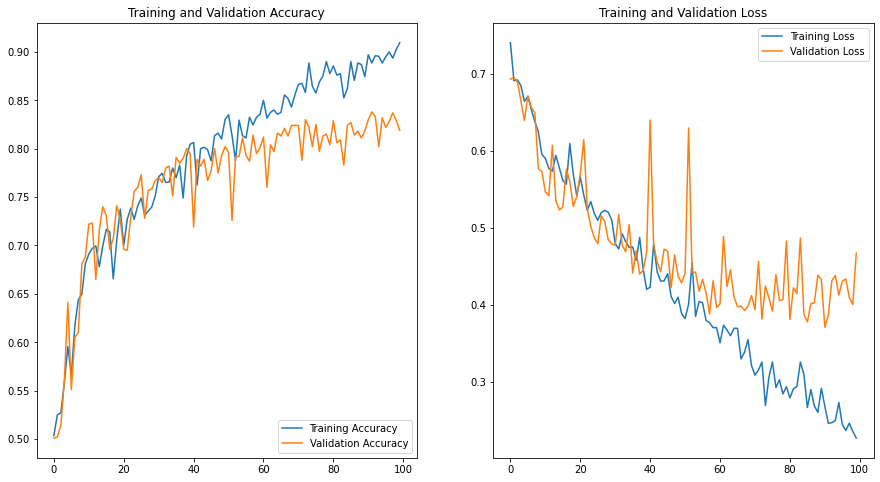

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()